In [ ]:
# default_exp data.image

# Image

> Basic functionalities to work with geospatial image data (geotiff). Work in process

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
# export
import rasterio as rio
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import pandas as pd

In [ ]:
# hide
from pathlib import Path
import os
import random
import re
from fastcore.test import *

In [ ]:
# export
def open_geotiff(fn, bands:List[int]=None) -> np.ndarray:
    """Open geotiff image from path, cast it to float and scale it to 0-1 range, optionally with only `bands` input bands."
    Returns numpy array of shape (C,W,H)
    """
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
        data /= 255.
    if bands is not None: data = data[bands]
    return data

In [ ]:
data_path = Path('data/')
example = '914153.tif'

tiffile = open_geotiff(data_path/example, bands=[0])
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 1)
assert tiffile.min() >= 0
assert tiffile.max() <= 1

tiffile = open_geotiff(data_path/example, bands=[0,1])
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 2)
assert tiffile.min() >= 0
assert tiffile.max() <= 1

tiffile = open_geotiff(data_path/example)
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 3)
assert tiffile.min() >= 0
assert tiffile.max() <= 1

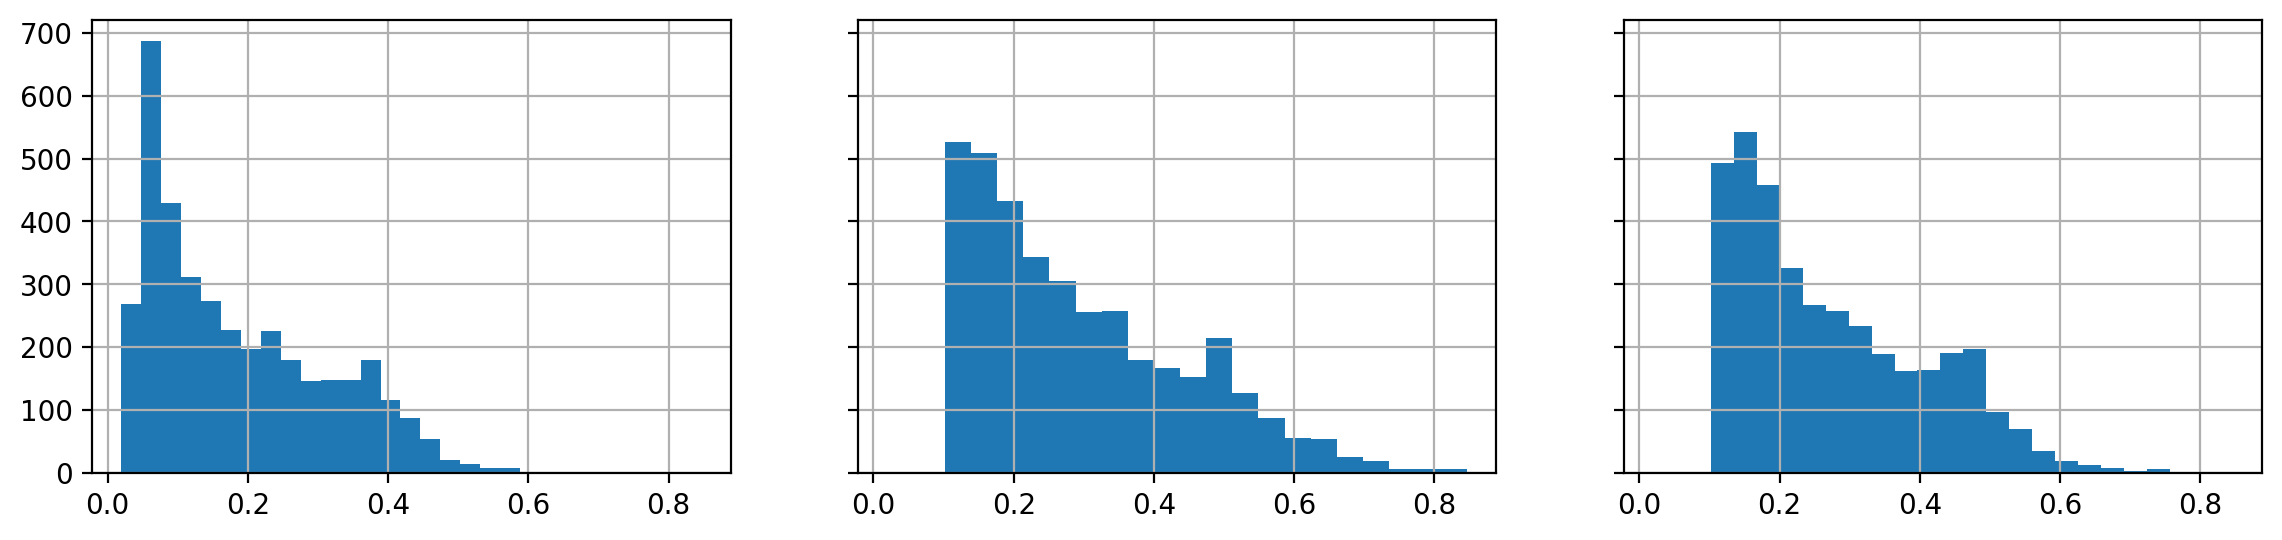

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(14,3), dpi=200, sharey=True, sharex=True)
for i in range(3):
    axs[i].hist(tiffile[i].ravel(), bins=20)
    axs[i].grid()

# Spectral indices

In [ ]:
# export 
def calc_normalized_spectral_index(im:np.ndarray, band_1:int, band_2:int) -> np.ndarray:
    "Calculate normalized spectral index (band_1 - band_2)/(band_1 + band_2). Can be used with NDVI and such simple indices"
    return (im[band_1] - im[band_2]) / (im[band_1] + im[band_2])

def calc_avi(im:np.ndarray, nir:int, red:int) -> np.ndarray:
    "Calculate AVI (nir *(1-red) * (nir-red))"
    return im[nir] * (1 - im[red]) * (nir - red)

def calc_savi(im:np.ndarray, nir:int, red:int, l:float=0.5) -> np.ndarray:
    "Calculate Soil Adjusted Vegetation Index ((nir-red)/(nir+red+l)) * (1+l). Default uses Landsat coefficient L"
    return ((im[nir] - im[red]) / (im[nir] + im[red] + l)) * (1 + l)

def calc_gci(im:np.ndarray, nir:int, green:int) -> np.ndarray:
    "Calculate Green Clorophyll Index nir/green - 1"
    return im[nir] / im[green] - 1

It's possible to add indices with `np.vstack`

In [ ]:
tiffile_ndvi = np.vstack((tiffile, calc_normalized_spectral_index(tiffile, 1, 0)[None]))
tiffile_ndvi.shape

(4, 61, 61)

Show what the different bands and indices look like. Example image is NIR-Red-Green false color image, so for instance NDVI is calculated with indices 0 and 1.

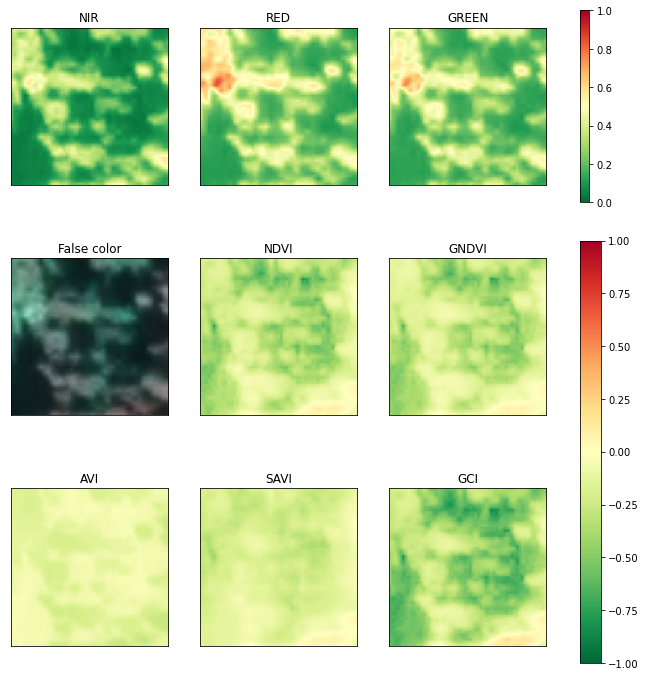

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(12,12), gridspec_kw={})

for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

#NIR
im = axs[0,0].imshow(tiffile[0], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,0].set_title('NIR')

#RED
axs[0,1].imshow(tiffile[1], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,1].set_title('RED')

#GREEN
axs[0,2].imshow(tiffile[2], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,2].set_title('GREEN')

#False color
axs[1,0].imshow(tiffile.swapaxes(0,2).swapaxes(0,1))
axs[1,0].set_title('False color')

fig.colorbar(im, ax=axs[0,:].ravel().tolist())

#NDVI
idx = axs[1,1].imshow(calc_normalized_spectral_index(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[1,1].set_title('NDVI')

#GNDVI
axs[1,2].imshow(calc_normalized_spectral_index(tiffile, 0, 2), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[1,2].set_title('GNDVI')

#AVI
axs[2,0].imshow(calc_avi(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,0].set_title('AVI')

#SAVI
axs[2,1].imshow(calc_savi(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,1].set_title('SAVI')

#GCI
axs[2,2].imshow(calc_gci(tiffile, 0, 2), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,2].set_title('GCI')

fig.colorbar(idx, ax=axs[1:,:].ravel().tolist())

plt.show()

# Circular masking

Function to mask all pixels from images. Example resolution is ~30cm, so 31 pixel radius more or less corresponds to 9m radius

In [ ]:
# export 

def mask_plot_from_image(data:np.ndarray, radius:float=31) -> np.ndarray:
    "Select only data from within field plot of radius (radius-1) pixels"
    center = (int(data.shape[1]/2), int(data.shape[2]/2))
    Y, X = np.ogrid[:data.shape[1], :data.shape[2]]
    dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)
    mask = dist_from_center <= radius
    data[:,~mask] = np.nan
    return data

In [ ]:
tiffile = open_geotiff(data_path/example, bands=[0])
tiffile = mask_plot_from_image(tiffile)
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 1)
assert np.nanmin(tiffile) >= 0
assert np.nanmax(tiffile) <= 1

tiffile = open_geotiff(data_path/example, bands=[0,1])
tiffile = mask_plot_from_image(tiffile)
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 2)
assert np.nanmin(tiffile) >= 0
assert np.nanmax(tiffile) <= 1

tiffile = open_geotiff(data_path/example)
tiffile = mask_plot_from_image(tiffile)
test_eq(type(tiffile), np.ndarray)
test_eq(tiffile.shape[0], 3)
assert np.nanmin(tiffile) >= 0
assert np.nanmax(tiffile) <= 1

Test that circular mask works

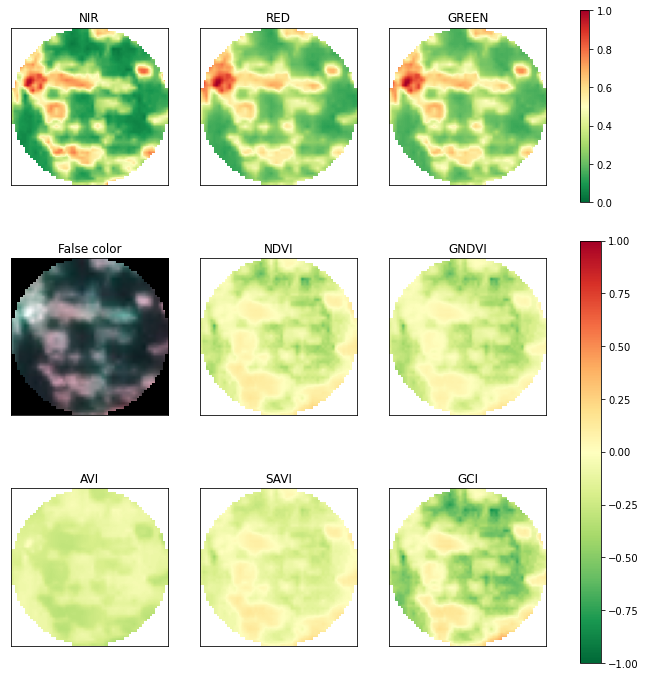

In [ ]:
fig, axs = plt.subplots(3,3, figsize=(12,12), gridspec_kw={})

for a in axs.flatten(): 
    a.set_xticks([])
    a.set_yticks([])

#NIR
im = axs[0,0].imshow(tiffile[0], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,0].set_title('NIR')

#RED
axs[0,1].imshow(tiffile[1], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,1].set_title('RED')

#GREEN
axs[0,2].imshow(tiffile[2], vmin=0, vmax=1, cmap='RdYlGn_r')
axs[0,2].set_title('GREEN')

#False color
axs[1,0].imshow(tiffile.swapaxes(0,2).swapaxes(0,1))
axs[1,0].set_title('False color')

fig.colorbar(im, ax=axs[0,:].ravel().tolist())


#NDVI
idx = axs[1,1].imshow(calc_normalized_spectral_index(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[1,1].set_title('NDVI')

#GNDVI
axs[1,2].imshow(calc_normalized_spectral_index(tiffile, 0, 2), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[1,2].set_title('GNDVI')

#AVI
axs[2,0].imshow(calc_avi(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,0].set_title('AVI')

#SAVI
axs[2,1].imshow(calc_savi(tiffile, 0, 1), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,1].set_title('SAVI')

#GCI
axs[2,2].imshow(calc_gci(tiffile, 0, 2), vmin=-1, vmax=1, cmap='RdYlGn_r')
axs[2,2].set_title('GCI')

fig.colorbar(idx, ax=axs[1:,:].ravel().tolist())

plt.show()

# Process image data into tabular models

Tuominen et al (2016), extract the following features

1. Spectral averages of orthoimage pixel values
2. Standard deviations of orthoimage pixel values
3. Textural features based on co-occurrence matrices of orthoimage pixel values of NIR, R, G & H
  1. Sum Average
  2. Entropy 
  3. Difference Entropy
  4. Sum Entropy
  5. Variance
  6. Difference Variance
  7. Sum Variance
  8. Angular Second Moment (Uniformity)
  9. Inverse Difference Moment (Homogeneity)
  10. Contrast
  11. Correlation
  12. Information Measures of Correlation (E.g. COR_R = correlation of red channel)

In [ ]:
#export

def calc_band_features(image:np.ndarray, band_idx:int=0):
    "Get basic features from a single input band: Max, min, mean, std and coefficient of variation"
    band_max = np.nanmax(image[band_idx])
    band_min = np.nanmin(image[band_idx])
    band_mean = np.nanmean(image[band_idx])
    band_std = np.nanstd(image[band_idx])
    band_cv = band_std / band_mean
    return [band_max, band_min, band_mean, band_std, band_cv]

def get_band_feature_cols(band_name):
    return [f'{band_name}_max', f'{band_name}_min', f'{band_name}_mean', 
            f'{band_name}_std', f'{band_name}_cv']

In [ ]:
assert(len(calc_band_features(tiffile, 1)) ==  len(get_band_feature_cols('nir')))
assert(len(calc_band_features(calc_normalized_spectral_index(tiffile, 0, 2))) == len(get_band_feature_cols('ndvi')))

In [ ]:
#export

def image_metrics(fn, mask_plot:bool=True, radius:int=31) -> list:
    "Calculate metrics from NIR-red-green -images"
    image = open_geotiff(fn)
    if mask_plot == True: image = mask_plot_from_image(image, radius=radius)
    # Max, mean, std and coefficient of variation
    nir_max = np.nanmax(image[0])
    nir_min = np.nanmin(image[0])
    nir_mean = np.nanmean(image[0])
    nir_std = np.nanstd(image[0])
    nir_cv = nir_std / nir_mean
    
    red_max = np.nanmax(image[1])
    red_min = np.nanmin(image[1])
    red_mean = np.nanmean(image[1])
    red_std = np.nanstd(image[1])
    red_cv = red_std / red_mean
    
    green_max = np.nanmax(image[2])
    green_min = np.nanmin(image[2])
    green_mean = np.nanmean(image[2])
    green_std = np.nanstd(image[2])
    green_cv = green_std / green_mean
    
    # spectral indices
    # NDVI
    ndvi = calc_normalized_spectral_index(image, 0, 1)
    ndvi_max = np.nanmax(ndvi)
    ndvi_min = np.nanmin(ndvi)
    ndvi_mean = np.nanmean(ndvi)
    ndvi_std = np.nanstd(ndvi)
    ndvi_cv = ndvi_std / ndvi_mean
    
    # GNDVI
    gndvi = calc_normalized_spectral_index(image, 0, 2)
    gndvi_max = np.nanmax(gndvi)
    gndvi_min = np.nanmin(gndvi)
    gndvi_mean = np.nanmean(gndvi)
    gndvi_std = np.nanstd(gndvi)
    gndvi_cv = gndvi_std / gndvi_mean
    
    # AVI
    avi = calc_avi(image, 0, 1)
    avi_max = np.nanmax(avi)
    avi_min = np.nanmin(avi)
    avi_mean = np.nanmean(avi)
    avi_std = np.nanstd(avi)
    avi_cv = avi_std / avi_mean
    
    # SAVI
    savi = calc_savi(image, 0, 1)
    savi_max = np.nanmax(savi)
    savi_min = np.nanmin(savi)
    savi_mean = np.nanmean(savi)
    savi_std = np.nanstd(savi)
    savi_cv = savi_std/savi_mean
    
    # GCI
    gci = calc_gci(image, 0, 2)
    gci_max = np.nanmax(gci)
    gci_min = np.nanmin(gci)
    gci_mean = np.nanmean(gci)
    gci_std = np.nanstd(gci)
    gci_cv = gci_std/gci_mean
    
    return [nir_max, nir_min, nir_mean, nir_std, nir_cv,
            red_max, red_min, red_mean, red_std, red_cv,
            green_max, green_min, green_mean, green_std, green_cv,
            ndvi_max, ndvi_min, ndvi_mean, ndvi_std, ndvi_cv,
            gndvi_max, gndvi_min, gndvi_mean, gndvi_std, gndvi_cv,
            avi_max, avi_min, avi_mean, avi_std, avi_cv,
            savi_max, savi_min, savi_mean, savi_std, savi_cv,
            gci_max, gci_min, gci_mean, gci_std, gci_cv]

image_metric_cols = ['nir_max', 'nir_min', 'nir_mean', 'nir_std', 'nir_cv',
                     'red_max', 'red_min', 'red_mean', 'red_std', 'red_cv',
                     'green_max', 'green_min', 'green_mean', 'green_std', 'green_cv',
                     'ndvi_max', 'ndvi_min', 'ndvi_mean', 'ndvi_std', 'ndvi_cv',
                     'gndvi_max', 'gndvi_min', 'gndvi_mean', 'gndvi_std', 'gndvi_cv',
                     'avi_max', 'avi_min', 'avi_mean', 'avi_std', 'avi_cv',
                     'savi_max', 'savi_min', 'savi_mean', 'savi_std', 'savi_cv',
                     'gci_max', 'gci_min', 'gci_mean', 'gci_std', 'gci_cv']

In [ ]:
# TODO more tests

example_metrics = image_metrics(data_path/example)
test_eq(type(example_metrics), list)
for m in example_metrics:
    test_eq(type(m), np.float32)
test_eq(len(example_metrics), len(image_metric_cols))

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_data.image.ipynb.
Converted 01_data.las.ipynb.
Converted 02_tabular.preprocessing.ipynb.
Converted 03_model.inception3dv3.ipynb.
Converted 04_interpretation.ipynb.
Converted 05_metrics.ipynb.
Converted 06_model.ensemble.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/enveco/nbs/00_data.image.ipynb
converting /mnt/d/Users/E1005164/enveco/nbs/index.ipynb to README.md
